In [1]:
%autoreload 2

In [2]:
import os
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)


from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
import numpy as np
import tatsu
import tatsu.ast

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('../reward-machine'))
from src import fitness_energy_utils as utils
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *
from src import latest_model_paths

2024-08-16 15:55:41 - ast_utils - DEBUG    - Using cache folder: /Users/guydavidson/tmp/game_generation_cache


## Load games and fitness data

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)

fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

2024-08-16 15:55:44 - ast_utils - INFO     - Loading from cache file: /Users/guydavidson/tmp/game_generation_cache/interactive-beta-cache.pkl.gz
2024-08-16 15:55:45 - ast_utils - INFO     - Finished loading cache file: /Users/guydavidson/tmp/game_generation_cache/interactive-beta-cache.pkl.gz


['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_prop,variables_used_all,variables_used_prop,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1.0,1,1.0,...,0.969177,0.979573,0.965285,0.976289,0.977376,0.980148,0.915272,0.960175,0.999188,1.000000
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1.0,1,1.0,...,0.974875,0.978991,0.961082,0.972691,0.971810,0.980943,0.895362,0.910697,0.963311,0.973001
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1.0,1,1.0,...,0.954233,0.972808,0.000000,0.000000,0.000000,0.000000,0.841097,0.898279,0.946597,0.955042
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1.0,1,1.0,...,0.986178,0.982877,0.000000,0.000000,0.000000,0.000000,0.915272,0.960175,0.999188,1.000000
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1.0,1,1.0,...,0.984002,0.979782,0.000000,0.000000,0.000000,0.000000,0.964905,0.971973,0.972563,0.962818


## Set up some plotting utilities

In [4]:
SUBPLOTS_ADJUST_PARAMS = dict(top=0.925)
DEFAULT_IGNORE_METRICS = ['Timestamp']


FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = './figures'


def save_plot(save_path, bbox_inches='tight', should_print=False):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        save_path = os.path.abspath(save_path)
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')


# Full model quantiative results
The following cells reproduce Figure ED-3, the quantiative summary of our model's results.

First, we load the model:

In [5]:
# trace_filter_results_path = '../samples/trace_filter_results_max_exemplar_preferences_by_bcs_with_expected_values_2023_11_29_2023_12_05_1.pkl.gz'
model_key = 'max_exemplar_preferences_by_bcs_with_expected_values'
model_spec = latest_model_paths.MAP_ELITES_MODELS[model_key]
baseline_model = typing.cast(MAPElitesSampler, model_spec.load())

key_to_real_game_index = defaultdict(list)
real_game_index_to_key = {}
real_game_fitness_scores = []
ALL_REAL_GAME_KEYS = []
for i, ast in enumerate(game_asts):
    fitness_score, features = baseline_model._score_proposal(ast, return_features=True)  # type: ignore
    real_game_fitness_scores.append(fitness_score)
    key = baseline_model._features_to_key(ast, features)
    key_to_real_game_index[key].append(i)
    real_game_index_to_key[i] = key
    ALL_REAL_GAME_KEYS.append(key)

trace_filter_results = model_spec.load_trace_filter_data()
trace_filter_results.keys()

2024-08-16 15:55:46 - compile_predicate_statistics_full_database - INFO     - Loading data from files with query timeout 15
2024-08-16 15:56:08 - compile_predicate_statistics_full_database - INFO     - Creating DuckDB table...
2024-08-16 15:56:09 - compile_predicate_statistics_full_database - INFO     - Creating data table indices...
2024-08-16 15:56:29 - compile_predicate_statistics_full_database - INFO     - Loaded data, found 843825 rows


dict_keys(['summary', 'full'])

Next, set up a plotting function, and run it on the full model's results:

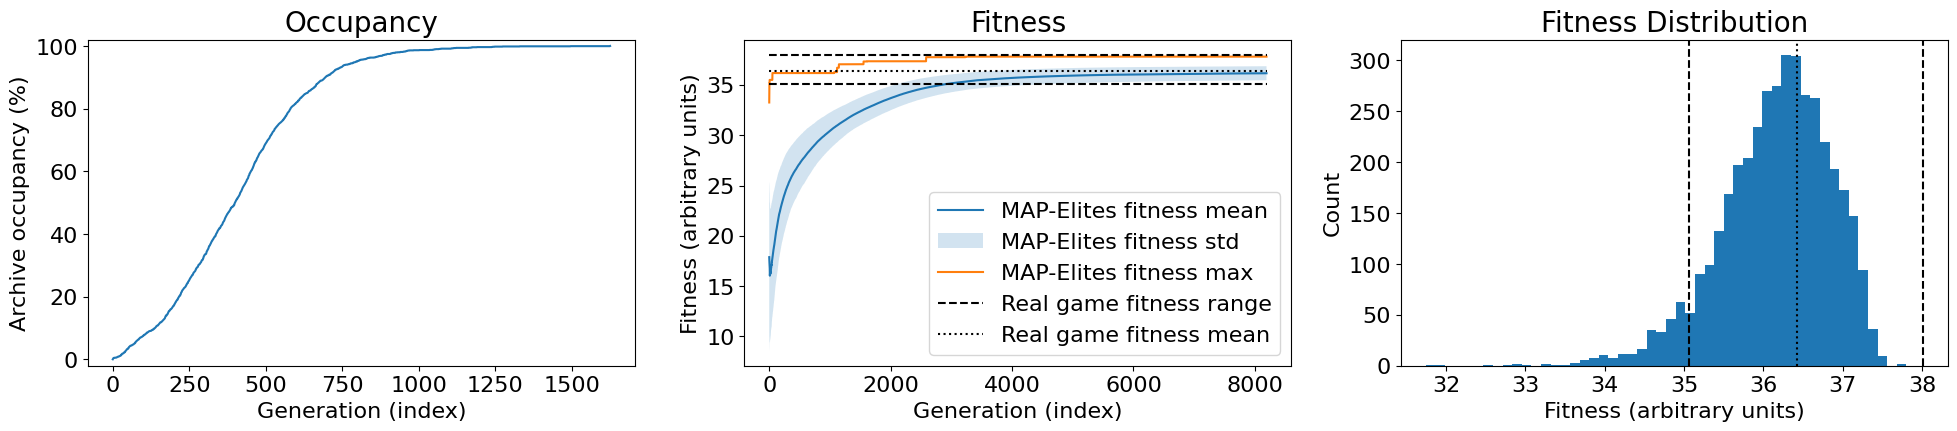

In [6]:
ARCHIVE_OCCUPANCY = 'archive_occupancy'


def plot_sampler_fitness_trajectory(
        evo: PopulationBasedSampler, title: typing.Optional[typing.List[str]] = None, 
        axsize: typing.Tuple[int, int] = (8, 6),
        plot_metrics: typing.Optional[bool] = None, 
        plot_fitness_histogram: bool = False,
        ignore_metrics: typing.Optional[typing.List[str]] = DEFAULT_IGNORE_METRICS,
        subplots_adjust_params: typing.Dict[str, float] = SUBPLOTS_ADJUST_PARAMS,
        min_real_game_fitness: typing.Optional[float] = None, 
        max_real_game_fitness: typing.Optional[float] = None,
        mean_real_game_fitness: typing.Optional[float] = None, 
        archive_occupancy_ignore_fake_bc: bool = True,
        n_archive_cells: typing.Optional[int] = None,
        fitness_left: bool = True,
        vertical: bool = False,
        fontsize: int = 16,
        save_path: typing.Optional[str] = None): 
    
    if min_real_game_fitness is None or max_real_game_fitness is None:    
        min_real_game_fitness =  -1 * evo.fitness_function.score_dict['max']
        max_real_game_fitness = -1 * evo.fitness_function.score_dict['min']
        mean_real_game_fitness = -1 * evo.fitness_function.score_dict['mean']

    if plot_metrics is None:
        plot_metrics = hasattr(evo, 'archive_metrics_history') and len(evo.archive_metrics_history) > 0  # type: ignore

    if ignore_metrics is None:
        ignore_metrics = []

    n_panels = 1 + (1 if plot_metrics else 0) + int(plot_fitness_histogram)
    
    if vertical:
        layout = (n_panels, 1)
    else:
        layout = (1, n_panels)

    figsize = (axsize[0] * layout[1], axsize[1] * layout[0])
    title_fontsize = fontsize + 4

    fig, axes = plt.subplots(*layout, figsize=figsize)

    mean, max_fit, std = [], [], []
    for step_dict in evo.fitness_metrics_history:
        mean.append(step_dict['mean'])
        max_fit.append(step_dict['max'])
        std.append(step_dict['std'])

    mean = np.array(mean)
    max_fit = np.array(max_fit)
    std = np.array(std)
    
    fitness_ax_index = 0 if fitness_left else 1
    fitness_ax = typing.cast(matplotlib.axes.Axes, axes[fitness_ax_index] if plot_metrics else axes)

    fitness_ax.plot(mean, label='MAP-Elites fitness mean')
    fitness_ax.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2, label='MAP-Elites fitness std')  # type; ignore
    fitness_ax.plot(max_fit, label='MAP-Elites fitness max')

    fitness_ax.hlines(min_real_game_fitness, 0, len(mean), label='Real game fitness range', color='black', ls='--')
    fitness_ax.hlines(max_real_game_fitness, 0, len(mean), color='black', ls='--')

    if mean_real_game_fitness is not None:
        fitness_ax.hlines(mean_real_game_fitness, 0, len(mean), label='Real game fitness mean', color='black', ls=':')

    fitness_ax.set_xlabel('Generation (index)', fontsize=fontsize)
    fitness_ax.set_ylabel('Fitness (arbitrary units)', fontsize=fontsize)

    fitness_ax.legend(loc='best', fontsize=fontsize)
    fitness_ax.tick_params(axis='both', which='major', labelsize=fontsize)

    if title is not None:
        if len(title) > 1 or not plot_metrics:
            fitness_ax.set_title(title[0], fontsize=title_fontsize)
        else:
            plt.suptitle(title[0], fontsize=title_fontsize)
    
    if plot_metrics:
        metrics_ax = typing.cast(matplotlib.axes.Axes, axes[1 - fitness_ax_index])

        if plot_metrics == ARCHIVE_OCCUPANCY:
            relevant_first_occupancies = evo.archive_cell_first_occupied  # type: ignore
            if archive_occupancy_ignore_fake_bc:
                relevant_first_occupancies = {k: v for k, v in relevant_first_occupancies.items() if k[0] == 1}

            first_occupancy_counter = Counter(relevant_first_occupancies.values())
            first_occupancy_arr = np.zeros(max(first_occupancy_counter.keys()) + 1)

            for k, v in first_occupancy_counter.items():
                first_occupancy_arr[k] = v

            first_occupancy_cumsum = np.cumsum(first_occupancy_arr)
            if n_archive_cells is None:
                n_archive_cells = first_occupancy_cumsum.max()
            first_occupancy_cumsum /= n_archive_cells

            metrics_ax.plot(first_occupancy_cumsum * 100)
            metrics_ax.set_xlabel('Generation (index)', fontsize=fontsize)
            metrics_ax.set_ylabel('Archive occupancy (%)', fontsize=fontsize)

            metrics_ax.set_ylim(-2, 102)

        else:
            metrics = {key: [] for key in evo.archive_metrics_history[0].keys() if key not in ignore_metrics}  # type: ignore
            for step_dict in evo.archive_metrics_history:  # type: ignore
                for key, value in step_dict.items():
                    if key in metrics:
                        metrics[key].append(value)

            
            for key, values in metrics.items():
                metrics_ax.plot(values, label=key.title())

            metrics_ax.set_xlabel('Generation', fontsize=fontsize)
            metrics_ax.set_ylabel('Number of games reaching threshold', fontsize=fontsize)

            metrics_ax.legend(loc='best', fontsize=fontsize)
        
        metrics_ax.tick_params(axis='both', which='major', labelsize=fontsize)

        if title is not None and len(title) > 1:
            metrics_ax.set_title(title[1], fontsize=title_fontsize)

    if plot_fitness_histogram:
        fitness_histogram_ax = typing.cast(matplotlib.axes.Axes, axes[-1])
        fitness_values = np.array(list(evo.fitness_values.values()) if isinstance(evo.fitness_values, dict) else evo.fitness_values)
        fitness_histogram_ax.hist(fitness_values, bins=50, density=False)  
        fitness_histogram_ax.set_xlabel('Fitness (arbitrary units)', fontsize=fontsize)
        fitness_histogram_ax.set_ylabel('Count', fontsize=fontsize)
        fitness_histogram_ax.tick_params(axis='both', which='major', labelsize=fontsize)

        y_max = fitness_histogram_ax.get_ylim()[1]

        fitness_histogram_ax.vlines(min_real_game_fitness, 0, y_max, label='Real game fitness range', color='black', ls='--')
        fitness_histogram_ax.vlines(max_real_game_fitness, 0, y_max, color='black', ls='--')

        if mean_real_game_fitness is not None:
            fitness_histogram_ax.vlines(mean_real_game_fitness, 0, y_max, label='Real game fitness mean', color='black', ls=':')

        fitness_histogram_ax.set_ylim(0, y_max)


        if title is not None and len(title) > 2:
            fitness_histogram_ax.set_title(title[2], fontsize=title_fontsize)

    plt.subplots_adjust(**subplots_adjust_params)
        

    if save_path is not None:
        save_plot(save_path)

    plt.show()



plot_sampler_fitness_trajectory(baseline_model, ['Fitness', 'Occupancy', 'Fitness Distribution'], 
                                axsize=(8, 4), plot_metrics=ARCHIVE_OCCUPANCY, 
                                plot_fitness_histogram=True, fitness_left=False, n_archive_cells=2000,
                                save_path='baseline_quantitative_results.png')

# Prior-sampling only model

First, load the model

In [7]:
prior_only_model_key = 'prior_sampling_only'
prior_only_model_spec = latest_model_paths.MAP_ELITES_MODELS[prior_only_model_key]
prior_sampling_only_model = typing.cast(MAPElitesSampler, prior_only_model_spec.load())

Next, generate the panel, which we present as a supplementary figure

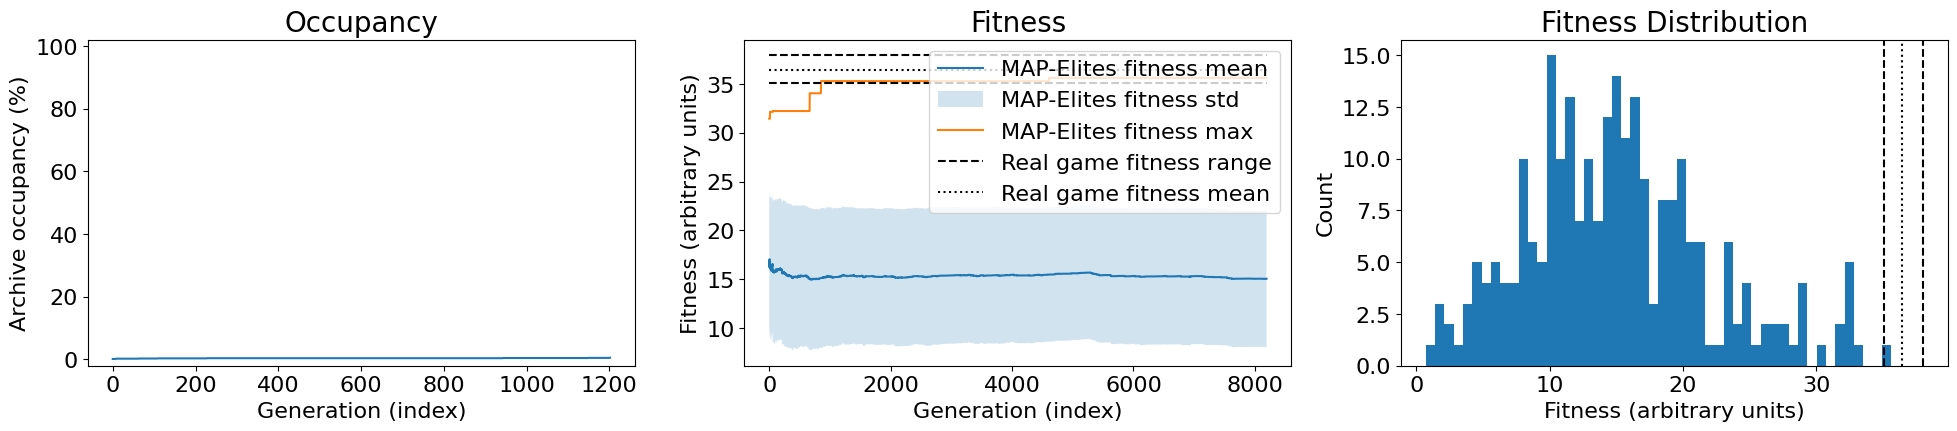

In [8]:
plot_sampler_fitness_trajectory(prior_sampling_only_model, ['Fitness', 'Occupancy', 'Fitness Distribution'], 
                                axsize=(8, 4), plot_metrics=ARCHIVE_OCCUPANCY, 
                                plot_fitness_histogram=True, fitness_left=False, n_archive_cells=2000,
                                save_path='prior_sampling_only_quantitative_results.png')

Descriptive statistics of the fitness scores

In [9]:
fitness_scores = np.array(list(prior_sampling_only_model.fitness_values.values()))
np.mean(fitness_scores), np.std(fitness_scores)

(15.042978286980633, 6.980215413235552)

How many of the samples from the prior pass our auxiliary check?

In [10]:
archive_keys = prior_sampling_only_model.population.keys()
n_passing_keys = sum(k[0] for k in archive_keys)
n_passing_keys, len(archive_keys), n_passing_keys / len(archive_keys)

(11, 251, 0.043824701195219126)